## Package Imports

In [1]:
import pandas as pd, numpy as np
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, classification_report
from mlxtend.evaluate import bootstrap
from numpy import format_float_scientific
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import tensorflow as tf
from keras.optimizers import adam
import keras
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import Model
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import warnings
warnings.filterwarnings("ignore")
import matplotlib
matplotlib.rcParams['figure.dpi']=300

/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda2/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

## Misc. Functions

In [44]:
def extract_ys(Y):
    return Y[:,0], Y[:,1]

def auc(Y):
    y_true, y_pred=extract_ys(Y)
    return roc_auc_score(y_true, y_pred)

def return_bootstrap_results(results,fn,round_place=1):
    Y=results[['y_true','y_pred_probs']].values
    original, std_err, ci_bounds = bootstrap(Y, num_rounds=1000,
                                             func=fn,
                                             ci=0.95,
                                             seed=123)
    std_err=format_float_scientific(std_err,round_place)
    if float(std_err) >= 0.001:
        std_err=float(std_err)
    
    return "{}±{}".format(float(format_float_scientific(original,round_place)),2*std_err)

## Import Data

In [45]:
data=pd.read_csv("../data/leukemia.csv",header=None)

## Generate outcome variable and randomly subselect columns to save compute time since this is a toy example

In [46]:
np.random.seed(42)
Y=data.iloc[:,0].map(lambda x: x.endswith("ALL")).astype(int)
X=data.iloc[:,:-1]
X=X.sample(axis='columns',n=30)

## Generate Train Test Splits

In [47]:
np.random.seed(42)
X_train,X_test,y_train,y_test = train_test_split(X,Y,train_size=0.7,stratify=Y,random_state=42)

## Train classification neural network
- 3-fold cross validation within training set (successive partitions of training set to select ideal hyperparameters)

In [53]:
def generate_model():
    model = Sequential()
    model.add(Dense(12, input_dim=30, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=adam(lr=1e-3, decay=1e-6), metrics=["accuracy"])
    return model

np.random.seed(42)
estimator=KerasClassifier
param_grid = dict(batch_size=[10, 20], epochs=[10, 50])
grid_search = GridSearchCV(estimator=estimator(build_fn=generate_model,verbose=0), param_grid=param_grid, scoring='roc_auc', cv=5, verbose=False)
grid_search.fit(X_train,y_train)
best_params=grid_search.best_params_

options=best_params
options.update(dict(build_fn=generate_model,verbose=0))
best_estimator=estimator(**options)
best_estimator.fit(X_train,y_train)
y_pred=best_estimator.predict(X_test)
y_pred_probs=best_estimator.predict_proba(X_test)[:,1]



## Classification performance on test set


In [54]:
print(classification_report(y_test,y_pred))
df_confusion=pd.DataFrame(confusion_matrix(y_test,y_pred))
df_confusion.index=pd.MultiIndex.from_frame(pd.DataFrame([("Prediction",x) for x in [0,1]]))
df_confusion.columns=pd.MultiIndex.from_frame(pd.DataFrame([("Reference",x) for x in [0,1]]))
df_confusion

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.86      0.86      0.86        14

    accuracy                           0.82        22
   macro avg       0.80      0.80      0.80        22
weighted avg       0.82      0.82      0.82        22



0            Reference    
1                    0   1
0          1              
Prediction 0         6   2
           1         2  12

## Receiver operating characteristic curve and concordance on test set


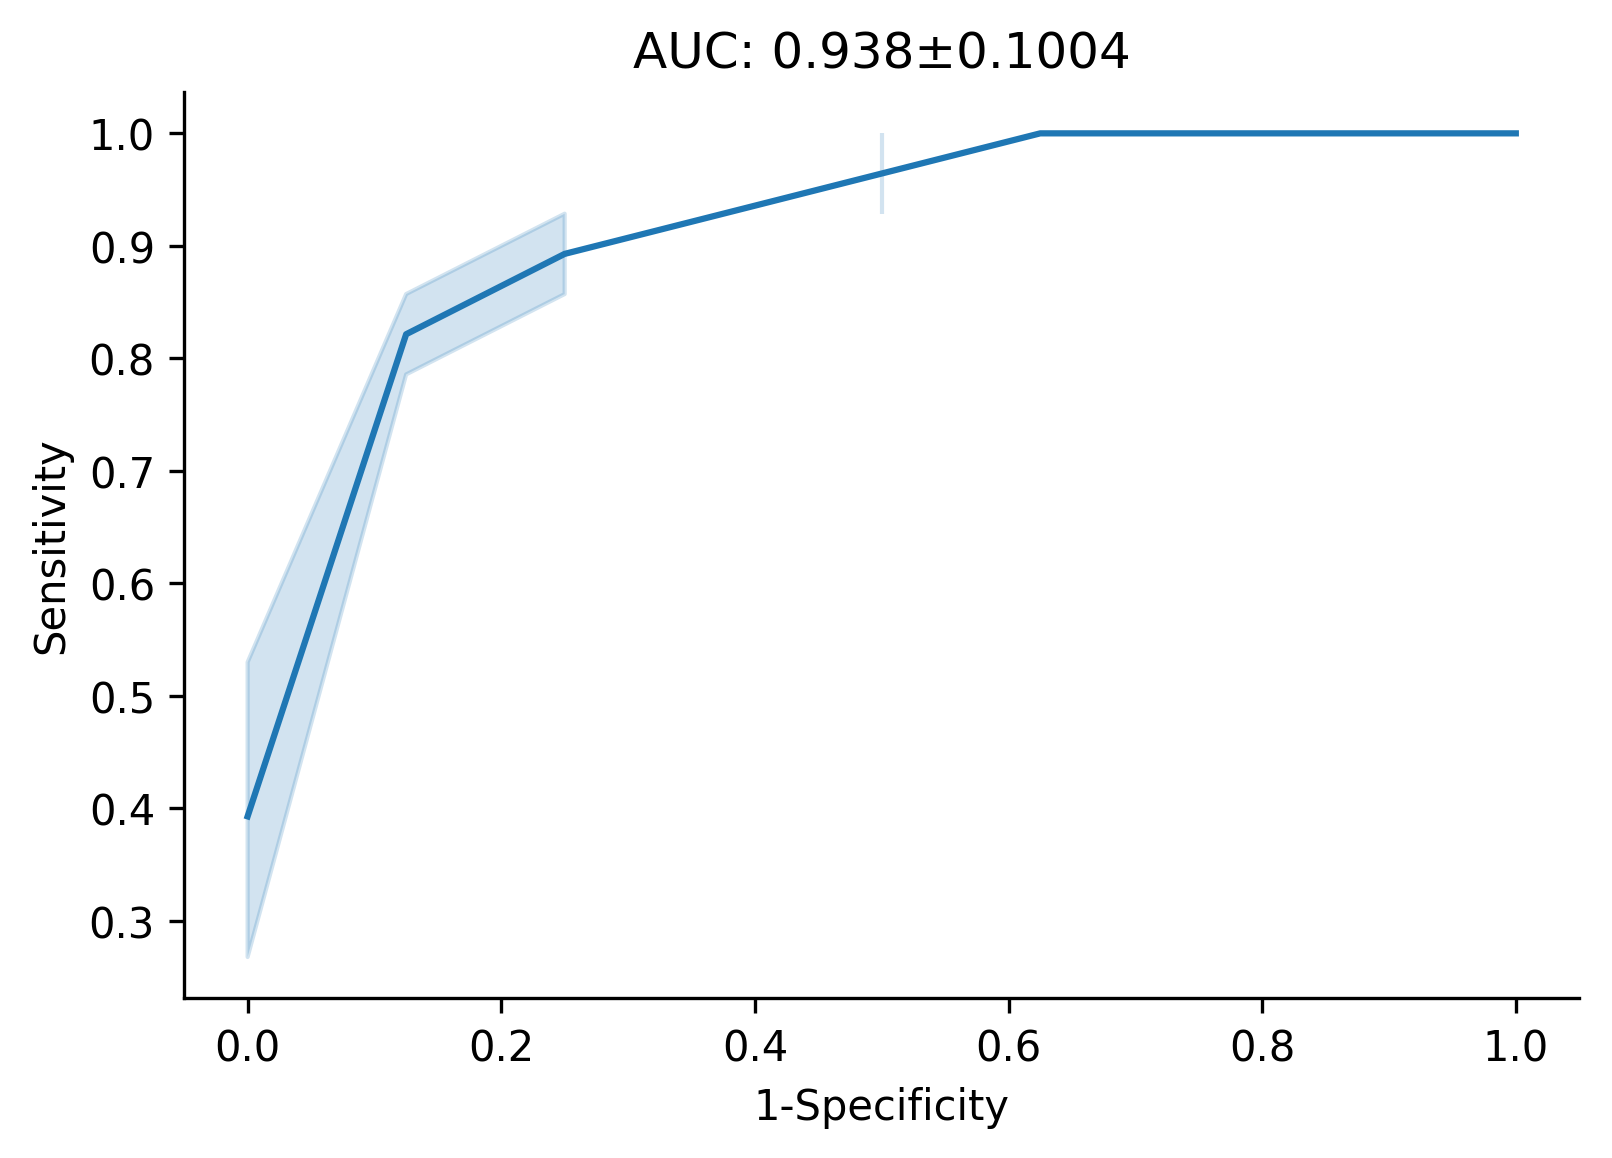

In [59]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs, drop_intermediate=False)
roc_df = pd.DataFrame(np.vstack([fpr,tpr,thresholds]).T,columns=['1-Specificity','Sensitivity','Thresholds'])
results=pd.DataFrame(np.vstack([y_test.values,y_pred.flatten(),y_pred_probs]).T,columns=['y_true','y_pred','y_pred_probs'])

plt.figure()
ax=sns.lineplot('1-Specificity','Sensitivity',data=roc_df)
plt.title("AUC: {}".format(return_bootstrap_results(results,auc,2)))
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
sns.despine()

# Unsupervised Learning
# Generate autoencoder for unsupervised dimensionality reduction
- autoencoder is comprised of:  
  - an encoder, which projects the data, X -> Z  
  - a decoder, which reconstructs the original data, Z -> X
  
# Generate network, Fit and Plot

In [99]:
def generate_model():
    model = Sequential()
    # encoder layers
    model.add(Dense(12, input_dim=30, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(2, activation='relu',name="hidden"))
    model.add(Dropout(rate=0.1))
    # decoder layers
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(30))
    model.compile(loss='mean_squared_error', optimizer=adam(lr=1e-2, decay=1e-6), metrics=["mean_squared_error"])
    return model

np.random.seed(42)
estimator=KerasRegressor(build_fn=generate_model,verbose=1,batch_size=32,epochs=300)
estimator.fit(X,X)
estimator.model.compile(loss='mean_squared_error', optimizer=adam(lr=1e-3, decay=1e-6), metrics=["mean_squared_error"])

Epoch 1/300
72/72 [==============================] - 4s 52ms/step - loss: 0.9879 - mean_squared_error: 0.9879
Epoch 2/300
72/72 [==============================] - 0s 193us/step - loss: 0.9745 - mean_squared_error: 0.9745
Epoch 3/300
72/72 [==============================] - 0s 212us/step - loss: 0.9633 - mean_squared_error: 0.9633
Epoch 4/300
72/72 [==============================] - 0s 193us/step - loss: 0.9537 - mean_squared_error: 0.9537
Epoch 5/300
72/72 [==============================] - 0s 189us/step - loss: 0.9473 - mean_squared_error: 0.9473
Epoch 6/300
72/72 [==============================] - 0s 180us/step - loss: 0.9498 - mean_squared_error: 0.9498
Epoch 7/300
72/72 [==============================] - 0s 176us/step - loss: 0.9370 - mean_squared_error: 0.9370
Epoch 8/300
72/72 [==============================] - 0s 190us/step - loss: 0.9168 - mean_squared_error: 0.9168
Epoch 9/300
72/72 [==============================] - 0s 177us/step - loss: 0.9319 - mean_squared_error: 0.9319
Ep

72/72 [==============================] - 0s 183us/step - loss: 0.7915 - mean_squared_error: 0.7915
Epoch 146/300
72/72 [==============================] - 0s 187us/step - loss: 0.7674 - mean_squared_error: 0.7674
Epoch 147/300
72/72 [==============================] - 0s 166us/step - loss: 0.7855 - mean_squared_error: 0.7855
Epoch 148/300
72/72 [==============================] - 0s 155us/step - loss: 0.7754 - mean_squared_error: 0.7754
Epoch 149/300
72/72 [==============================] - 0s 156us/step - loss: 0.7924 - mean_squared_error: 0.7924
Epoch 150/300
72/72 [==============================] - 0s 194us/step - loss: 0.8071 - mean_squared_error: 0.8071
Epoch 151/300
72/72 [==============================] - 0s 193us/step - loss: 0.8275 - mean_squared_error: 0.8275
Epoch 152/300
72/72 [==============================] - 0s 210us/step - loss: 0.7730 - mean_squared_error: 0.7730
Epoch 153/300
72/72 [==============================] - 0s 220us/step - loss: 0.7835 - mean_squared_error: 0.78

72/72 [==============================] - 0s 182us/step - loss: 0.7874 - mean_squared_error: 0.7874
Epoch 290/300
72/72 [==============================] - 0s 172us/step - loss: 0.7682 - mean_squared_error: 0.7682
Epoch 291/300
72/72 [==============================] - 0s 171us/step - loss: 0.7781 - mean_squared_error: 0.7781
Epoch 292/300
72/72 [==============================] - 0s 173us/step - loss: 0.7549 - mean_squared_error: 0.7549
Epoch 293/300
72/72 [==============================] - 0s 170us/step - loss: 0.7814 - mean_squared_error: 0.7814
Epoch 294/300
72/72 [==============================] - 0s 176us/step - loss: 0.7740 - mean_squared_error: 0.7740
Epoch 295/300
72/72 [==============================] - 0s 184us/step - loss: 0.7936 - mean_squared_error: 0.7936
Epoch 296/300
72/72 [==============================] - 0s 176us/step - loss: 0.7648 - mean_squared_error: 0.7648
Epoch 297/300
72/72 [==============================] - 0s 173us/step - loss: 0.7884 - mean_squared_error: 0.78

In [100]:
estimator.model = Model(inputs=estimator.model.input, outputs=estimator.model.get_layer('hidden').output)

72/72 [==============================] - 3s 47ms/step


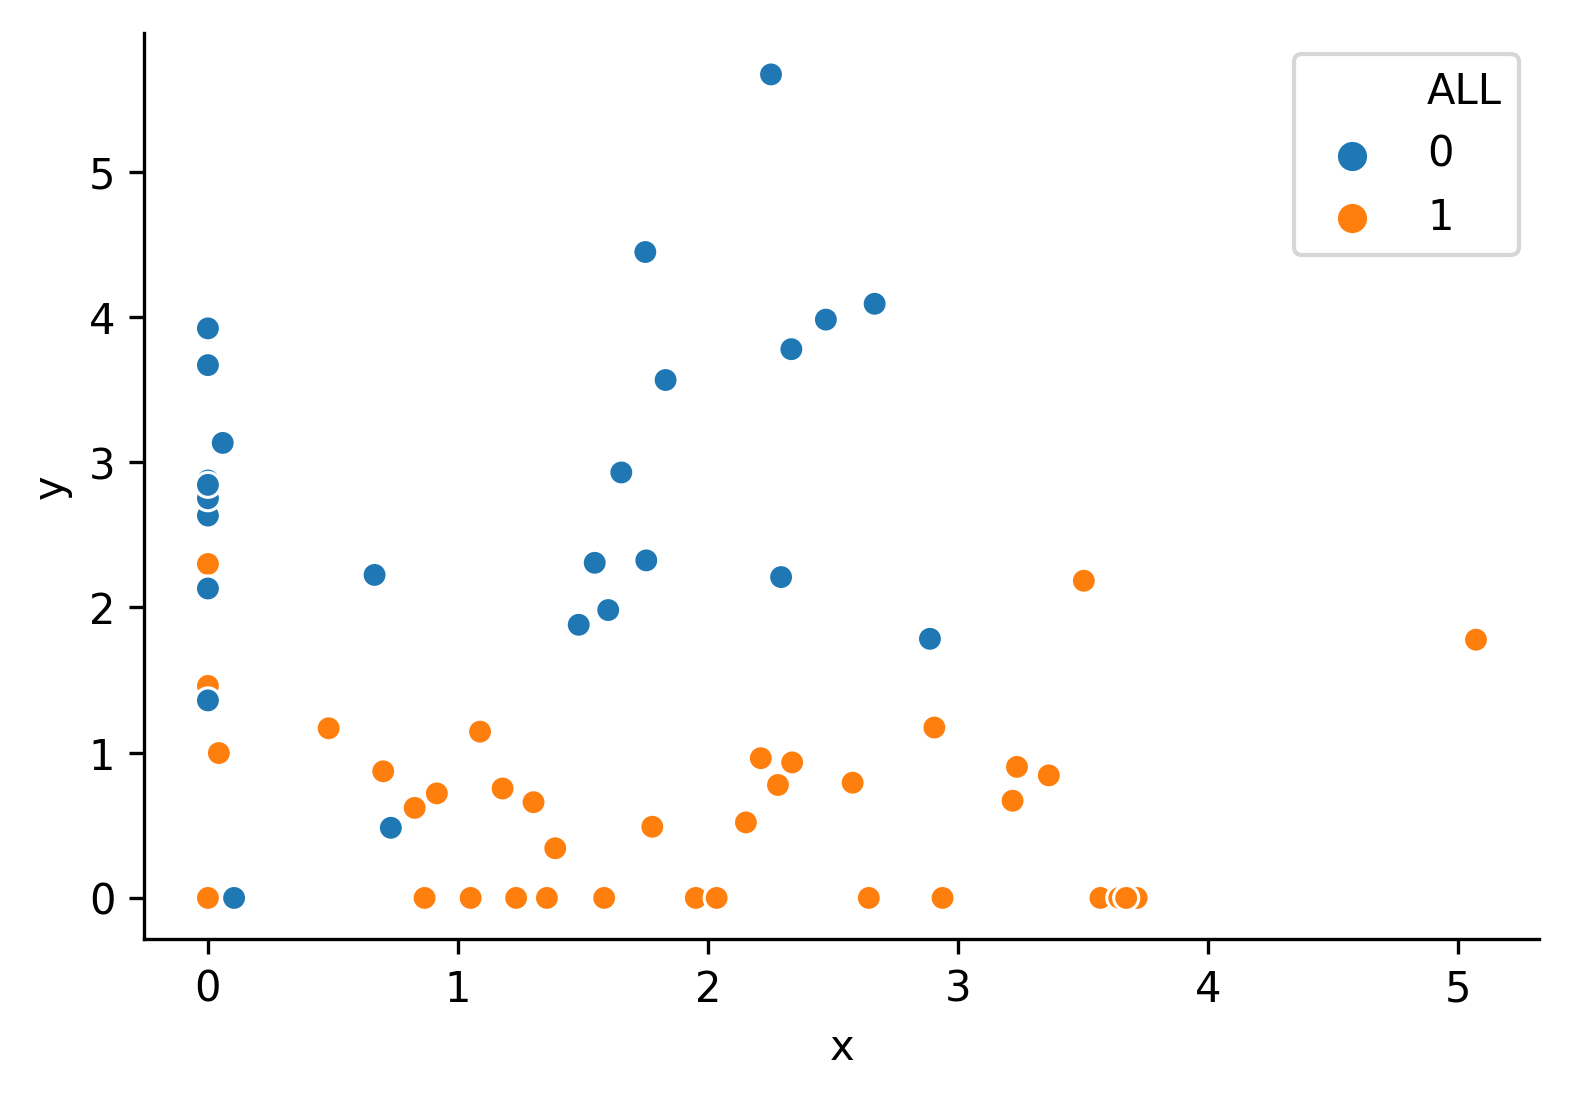

In [101]:
t_data=pd.DataFrame(estimator.predict(X),columns=['x','y'])
t_data['ALL']=Y
sns.scatterplot(x='x',y='y',hue="ALL",data=t_data)
sns.despine()

## PCA

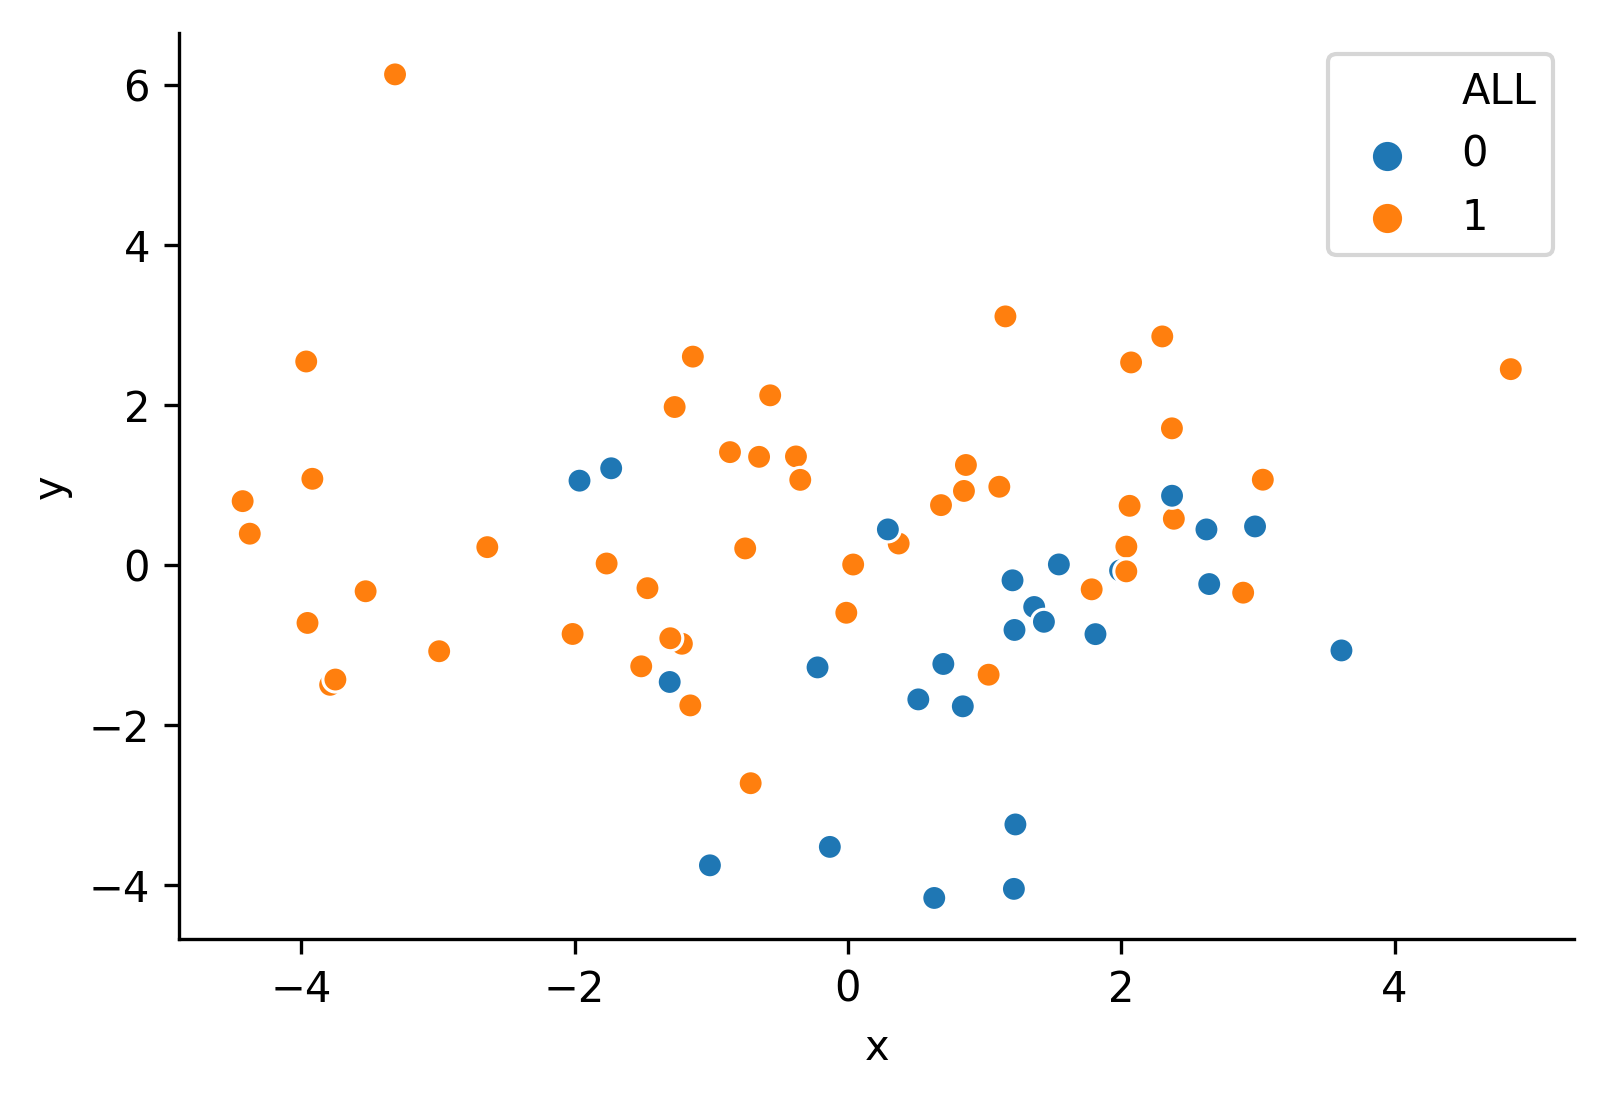

In [90]:
np.random.seed(42)
t_data=pd.DataFrame(PCA(n_components=2,random_state=42).fit_transform(X),columns=['x','y'])
t_data['ALL']=Y
sns.scatterplot(x='x',y='y',hue="ALL",data=t_data)
sns.despine()